### Важно:
Пожалуйста, поддерживайте ваш код в хорошем состоянии, пишите комментарии, убирайте бесполезные ячейки, пишите модели в специально отведенных модулях. Проверяющие могут **НА СВОЕ УСМОТРЕНИЕ** снижать баллы за:

1. Говнокод
2. Неэффективные решения
3. Вермишель из ячеек в тетрадке
4. Все остальное что им не понравилось

#### (0 - 0.05 балла):

За использование логгеров типа wandb/comet/neptune и красивую сборку этой домашки в виде графиков/картинок в этих логгерах мы будем выдавать бонусные баллы.

Решением домашки является архив с использованными тетрадками/модулями, а так же **.pdf** файл с отчетом по проделанной работе по каждому пункту задачи. В нем необходимо описать какие эксперименты вы производили чтобы получить результат который вы получили, а так же обосновать почему вы решили использовать штуки которые вы использовали (например, дополнительные лоссы для стабилизации, разные виды потоков, разные хаки для вае)


In [23]:
import os

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

from tqdm.notebook import tqdm

import wandb

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
batch_size = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

celeba_transforms = transforms.Compose([
    transforms.Resize((32 , 32)),
    transforms.ToTensor(),
])


celeba = torchvision.datasets.MNIST('', transform=celeba_transforms, download=False)

data_size = len(celeba)
train_size = int(data_size * 0.99)

train_data, val_data = torch.utils.data.random_split(
                                celeba,
                                [train_size, data_size - train_size],
                                generator=torch.Generator().manual_seed(1337)
                       )

train_dataloader = torch.utils.data.DataLoader(
                        train_data, batch_size, shuffle=True, drop_last=True, num_workers=2
                   )
val_dataloader = torch.utils.data.DataLoader(
                        val_data, batch_size, shuffle=True, drop_last=True, num_workers=2
                 )

### Задача 1 (0.1 балла, но если не сделаете, за всю домашку ноль):

Для начала предлагаю попробовать обучить обычный VAE на Celeba до нормального качества, померить FID и запомнить для будущего сравнения


In [85]:
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform

In [86]:
prior = TransformedDistribution(Uniform(0, 1), SigmoidTransform().inv)

In [87]:
import torch.nn.functional as F

def loss_function(recon_x, x, mu, logvar):
    batch_size = recon_x.shape[0]
    MSE = F.mse_loss(recon_x.view(batch_size,-1), x.view(batch_size, -1), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE, KLD

In [88]:
def train(x, model, optimizer, criterion):
    model.train()
    
    rec_x, mean, logvar = model(x)
    rec_x = rec_x[-1]
    print(rec_x.shape)
    mse_loss, kld_loss = criterion(rec_x, x, mean, logvar)
    loss = mse_loss + kld_loss

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1)
    optimizer.step()

    return mse_loss.item(), kld_loss.item(), loss.item()

In [141]:
from glow import Glow, Flow, SimpleGlow


# model = Flow(1).to(device)

model = Glow(1, 4, 3).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.0001)


In [143]:
name = 'first big dick'

In [144]:
# train loop

EPOCH_NUM = 30
mean_z = [0] * 10
losses = []
for epoch in range(1, EPOCH_NUM + 1):
    model.train()
    for i, (image, _) in enumerate(tqdm(train_dataloader, leave=False, desc=f"trainloop: {epoch}")):
        image = image.to(device)
#         image = image.repeat(1, 2, 1, 1)
        z, log_det, log_pz = model(image)

        log_pz = -torch.sum(log_pz)
        log_det = -torch.sum(log_det)

        nll_loss = log_pz + log_det

        losses.append(nll_loss.item())
        model.zero_grad()
        nll_loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optim.step()
        
#         wandb.log({
#             "MSE loss": mse / len(image),
#             "KLD loss": kld / len(image),
#             "Sum loss": (mse + kld) / len(image)
#         })

        if i % 1000 == 999:
            torch.save(model.state_dict(), 'models/' + name)
#             val_fid = calculate_fid(val_dataloader, model, cls)
#             wandb.log({"FID": val_fid})

# mean_z = mean_z / EPOCH_NUM

trainloop: 1:   0%|          | 0/3712 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [49]:
from torch.distributions import Normal
# mean_z = mean_z.mean(dim=0)
loc = torch.zeros((1, 1, 28, 28))
scale = torch.ones((1, 1, 28, 28))
hidden = Normal(loc, scale).sample()

In [35]:
! ls models

In [125]:
model = Glow(1, 6, 3).to(device)

In [149]:
sample = train_data[1][0].unsqueeze(0).to(device)
model.eval()

with torch.no_grad():
    z, det, _ = model(sample)
    
    recon_x = model.backward(z)

In [154]:
z[2].shape

torch.Size([1, 16, 4, 4])

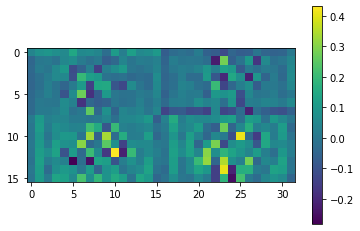

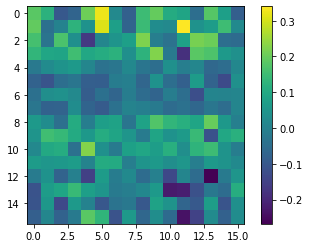

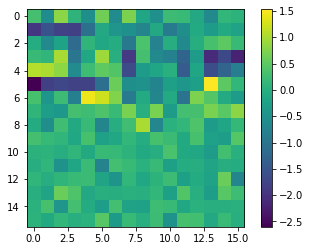

In [156]:
for i in range(len(z)):
    plt.imshow(z[i].view((16, -1)).cpu().detach().numpy())
    plt.colorbar()
    plt.show()
# det

In [158]:
z[0].mean(), z[0].std()

(tensor(0.0283), tensor(0.0945))

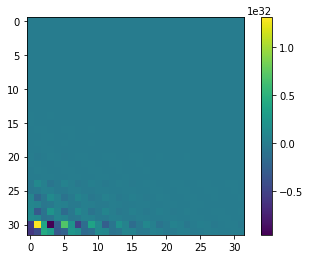

In [129]:
plt.imshow(recon_x.view((32, 32)).cpu().detach().numpy())
plt.colorbar()
# det

In [75]:
z

[tensor([[[[-2.2017e-02, -1.2860e-02, -1.2666e-02, -8.9128e-03, -4.4419e-03,
            -1.5183e-02, -1.6109e-02, -1.1378e-02, -1.3861e-02, -1.3005e-02,
            -1.3015e-02, -1.3016e-02, -1.2207e-02, -2.0372e-02],
           [-1.4463e-02, -2.1960e-03, -4.1993e-03, -3.4084e-04,  5.4314e-03,
            -8.7638e-03, -5.8916e-03, -3.2719e-03, -4.0357e-03, -3.7002e-03,
            -3.7048e-03, -3.7049e-03, -3.3797e-03, -1.4030e-02],
           [-1.5536e-02, -3.3417e-03, -6.1035e-03,  2.7592e-05,  1.0215e-02,
            -1.6717e-02, -1.2531e-03, -5.3460e-03, -4.3735e-03, -4.6566e-03,
            -4.7026e-03, -4.7397e-03, -4.4007e-03, -1.4477e-02],
           [-1.5505e-02, -3.3733e-03, -4.5846e-03, -8.9263e-04,  1.9037e-03,
            -8.7772e-03, -3.1778e-03, -5.0796e-03, -3.8562e-03, -4.6892e-03,
            -1.9139e-03, -5.3094e-03, -4.2175e-03, -1.4486e-02],
           [-1.5596e-02, -4.1745e-03, -7.5001e-04,  4.5267e-03, -9.2810e-03,
            -5.8503e-03, -7.1902e-03,  3.3942e-

### Задача 2 (0.3 балла, но если не сделаете, за всю домашку max 0.1 за прошлый пункт):

После этого попробуем обучить обычный NF на Celeba до нормального качества, померить FID и запомнить для будущего сравнения

В качестве потока можно использовать все что вы хотите, Coupling/Autoregressive/Linear слои, любые трансформации. 

Можно использовать как и сверточные потоки, так и линейные (развернув селебу в один вектор)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


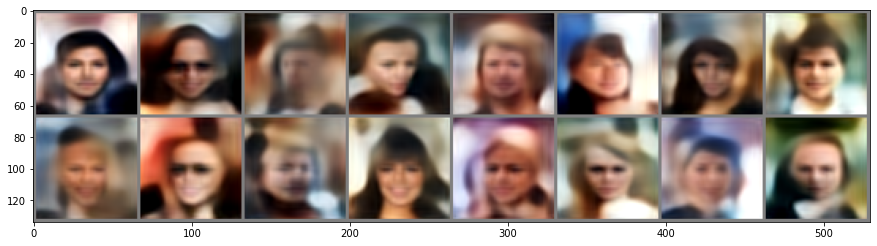

In [ ]:
with torch.no_grad():
    sample = model.sample(16).cpu()
    log_img = make_grid(sample)

plt.figure(figsize=(15,15))
plt.imshow(log_img.permute(1, 2, 0) * 0.5 + 0.5)

In [ ]:
def get_gradient(model, img1, img2, n_steps=5):
    z1, _ = model.encode(img1.unsqueeze(0).to(device))
    z2, _ = model.encode(img2.unsqueeze(0).to(device))

    z_init = torch.tensor([], device=device)
    for i in range(n_steps + 1):
        z = (z1 * (n_steps - i) + z2 * i) / float(n_steps)
        z_init = torch.cat((z_init, z))

    return torch.tanh(model.backward(z_init).cpu())

In [ ]:
from drive.MyDrive.GAN_HW3.realnvp import RealNVP

model = RealNVP(n_flows=10, n_blocks=3, device=device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
cls = get_classifier().to(device)

In [ ]:
wandb.init(project="gans_hw3", name="realNVP")

In [ ]:
model.train()

EPOCH_NUM = 1

for epoch in range(1, EPOCH_NUM + 1):
    for i, (image, _) in enumerate(tqdm(train_dataloader, leave=False, desc=f"trainloop: {epoch}")): 
        image = image.to(device)

        z, log_pz, log_det = model(image)

        log_pz = -torch.sum(log_pz)
        log_det = -torch.sum(log_det)

        nll_loss = log_pz + log_det

        model.zero_grad()
        nll_loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()


# -------------- LOGGING --------------

        wandb.log({"NLL loss": nll_loss.item(),
                   "Prior loss": log_pz.item(),
                   "Log det loss": log_det.item()})

        if i % 1000 == 999:
            val_fid = calculate_fid(val_dataloader, model, cls)
            wandb.log({"FID": val_fid})
        
        if i % 500 == 0:
            gen_images = process_example(model.sample(size=16).cpu())
            wandb.log({"examples": [wandb.Image(gen_images)]})


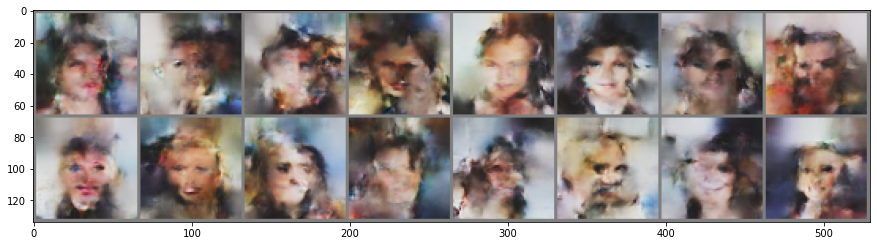

In [ ]:
result = torch.tanh(model.sample(size=16)).cpu()

log_img = make_grid(result)

plt.figure(figsize=(15,15))
plt.imshow(log_img.permute(1, 2, 0) * 0.5 + 0.5)

### Задача 3 (0.6 балла):

Попробуйте повторить архитектуру VAPNEV из https://arxiv.org/pdf/1611.05209.pdf. Сравните качество (FID) между тремя разными моделями

Здесь вы можете использовать VAE и NF из предыдущих пунктов, необходимо только понять как они совмещаются в оригинальной статье

В отчете напишите, почему по вашему мнению такой подход будет лучше (или может быть хуже) чем обычный VAE?



In [ ]:
def kl_loss(mu, logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp())
    return KLD

In [ ]:
from drive.MyDrive.GAN_HW3.vapnev import VAPNEV

model_vapnev = VAPNEV(n_nf_flow=3, n_nf_block=2, device=device).to(device)
optimizer = torch.optim.Adam(model_vapnev.parameters(), lr=1e-4)

In [ ]:
wandb.init(project="gans_hw3", name="VAPNEV")

In [ ]:
model_vapnev.train()

EPOCH_NUM = 1

for epoch in range(1, EPOCH_NUM + 1):
    for i, (image, _) in enumerate(tqdm(train_dataloader, leave=False, desc=f"trainloop: {epoch}")): 
        image = image.to(device)

        posterior_logprob, log_det, mean_z, logvar_z, y_outs = model_vapnev(image)

        kl_loss = get_kl_loss(mean_z, logvar_z)
        logprob = posterior_logprob + log_det
        loss = -torch.sum(logprob) + kl_loss

        model_vapnev.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model_vapnev.parameters(), 1)
        optimizer.step()

       # -------------- LOGGING --------------

        wandb.log({"Sum loss": loss.item(),
                   "KL loss": kl_loss.item(),
                   "Prior loss": posterior_logprob.mean().item(),
                   "Log det loss": log_det.sum().item()})
       
        if i % 1000 == 999:
            val_fid = calculate_fid(val_dataloader, model_vapnev, cls)
            wandb.log({"FID": val_fid})
        
        if i % 500 == 0:
            gen_images = process_example(model_vapnev.sample(size=16).cpu())
            wandb.log({"examples": [wandb.Image(gen_images)]})


### Бонусная задача (0.2 балла):

Найдите, реализуйте и сравните с предыдущими моделями еще один интересный способ совмещения NF и VAE

##### Подсказки:

1. Если вы учите на колабе или на наших машинках, вероятнее всего что обучение будет очень долгим на картинках 256х256. Никто не мешает уменьшить разрешение, главное чтобы было видно что генерация выучились и качество было ок

2. Вы можете сделать ваш VAE/NF/VAPNEV условным, придумав как вы будете передавать в него conditional аттрибуты селебы

3. Не забывайте про аугментации


